In [1]:
import pandas as pd
import numpy as np
from Models import PatientModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt


import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
dir = "../../../Data/Patient/DataSet"
target_columns = ['HF', 'RF', 'CI']
dataset = pd.read_parquet(dir, engine='pyarrow')

# Remove outliers
dataset = dataset[(dataset['Age'] >= 0) & (dataset['Age'] <= 95)]

# Keep only useful columns
dataset.drop(columns=['ID', 'Type'], inplace=True)

# Create a class column representing all 4 possible classes: HF, RF, CI, None
dataset['Class'] = dataset[target_columns].apply(lambda x: x.idxmax() if x.any() else 'None', axis=1)

print(dataset.shape)
dataset.head()

(1566410, 18)


,Date,Sex,Age,HT,AF,CIHD,COPD,VI,HF,RF,CI,Max,Min,Prec,Press,Wind,Insolat,Class
0,2007-02-16,M,0,0,0,0,0,0,0,0,0,8.0,1.5,1.8,1021.4,5,0.0,None
1,2007-02-16,F,0,0,0,0,0,0,0,0,0,8.0,1.5,1.8,1021.4,5,0.0,None
2,2007-02-16,F,0,0,0,0,0,0,0,0,0,8.0,1.5,1.8,1021.4,5,0.0,None
3,2007-02-16,M,0,0,0,0,0,0,0,0,0,8.0,1.5,1.8,1021.4,5,0.0,None
4,2007-02-16,M,0,0,0,0,0,0,0,0,0,8.0,1.5,1.8,1021.4,5,0.0,None


In [3]:
target_columns = ['HF', 'RF', 'CI']
X = dataset.drop(columns=target_columns + ['Class'])
y = dataset[target_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=dataset['Class'])

In [4]:
# scale the columns: 
scaled_features = ["Max", "Min", "Prec", "Press", "Wind", "Insolat"]
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[scaled_features] = scaler.fit_transform(X_train[scaled_features])
X_test_scaled[scaled_features] = scaler.transform(X_test[scaled_features])

## Experiments

**Experiment 1 - Importance of Algorithm**:
- Logistic Regression
- Gaussian Naive Bayes
- Support Vector Classifier
- KNN
- Decision Tree
- Random Forest
- XGBoost

**Experiment 2 - Importance of Medical and Weather Data**:
- All features
- No weather features
- No medical features

In [5]:
search_space = {
    "algorithm": [LogisticRegression, KNeighborsClassifier, DecisionTreeClassifier, RandomForestClassifier, XGBClassifier],
    "data": ["all", "no-weather", "no-medical"],
}

drop_columns = {
    "all": [],
    "no-medical": ["HT", "AF", "CIHD", "COPD", "VI"],
    "no-weather": ["Max", "Min", "Prec", "Press", "Wind", "Insolat"]
}

def run_experiments(search_space, drop_columns):
    results = {}
    for algorithm in tqdm(search_space["algorithm"], desc="Algorithm"):
        for data in search_space["data"]:

            model = PatientModel(classifier=algorithm)

            _drop_columns = drop_columns[data]

            if data == "all":
                _X_train = X_train_scaled
                _X_test = X_test_scaled
            elif data == "no-weather":
                _X_train = X_train.drop(columns=_drop_columns)
                _X_test = X_test.drop(columns=_drop_columns)
            else: 
                _X_train = X_train_scaled.drop(columns=_drop_columns)
                _X_test = X_test_scaled.drop(columns=_drop_columns)
                
            model.fit(_X_train, y_train)
            
            precision, recall, f1, auc_roc = model.evaluate(_X_test, y_test, verbose=False)
            results[(algorithm.__name__, data)] = {
                "Precision": precision,
                "Recall": recall,
                "F1": f1,
                "AUC_ROC": auc_roc
            }

    impacts = {"weather": [], "medical": []}
    for algorithm in search_space["algorithm"]:
        for data in ["weather", "medical"]:
            current_recall = results[(algorithm.__name__, f"no-{data}")]["Recall"]
            all_recall = results[(algorithm.__name__, "all")]["Recall"]
            if algorithm != KNeighborsClassifier:
                impacts[data].append((all_recall - current_recall) / current_recall)
    
    impacts = {k: np.mean(v) for k, v in impacts.items()}

    return results, impacts

In [6]:
results, impacts = run_experiments(search_space, drop_columns)
impacts

Algorithm: 100%|██████████| 5/5 [03:30<00:00, 42.02s/it]


{'weather': -0.001609706447272101, 'medical': 0.09830079952808607}

In [7]:
results = pd.DataFrame(results).T.round(2)
results

Precision  Recall    F1  AUC_ROC
LogisticRegression     all              0.76    0.78  0.77     0.77
                       no-weather       0.76    0.78  0.77     0.77
                       no-medical       0.66    0.70  0.68     0.67
KNeighborsClassifier   all              0.71    0.72  0.71     0.72
                       no-weather       0.76    0.50  0.59     0.67
                       no-medical       0.65    0.69  0.67     0.66
DecisionTreeClassifier all              0.69    0.69  0.69     0.69
                       no-weather       0.73    0.70  0.71     0.72
                       no-medical       0.63    0.61  0.62     0.62
RandomForestClassifier all              0.74    0.78  0.76     0.76
                       no-weather       0.73    0.77  0.75     0.74
                       no-medical       0.65    0.69  0.67     0.66
XGBClassifier          all              0.76    0.80  0.77     0.77
                       no-weather       0.76    0.80  0.78     0.77
                       no-medical       0.67    0.77  0.71     0.69

In [9]:
df = results["Recall"].reset_index().rename(columns={"level_0": "Algorithm", "level_1": "Features"})

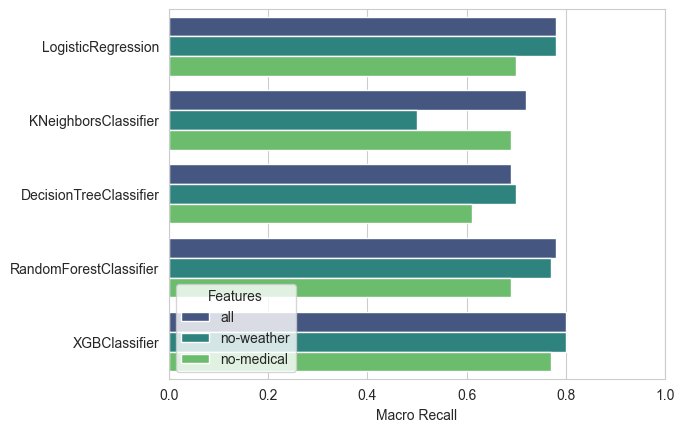

In [10]:
sns.set_style("whitegrid")

sns.barplot(data=df, y="Algorithm", hue="Features", x="Recall", palette="viridis", orient="h")
plt.legend(loc="lower left", title="Features")
plt.xlim(0, 1)
plt.ylabel(None)
plt.xlabel("Macro Recall")
plt.show()